# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\all_data


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [8]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 

data_file05 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_0.5.csv'
data_file10 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_1.01.csv'
data_file15 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_1.5.csv'
data_file3 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_3.0.csv'
data_file5 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_5.csv'
data_file7 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_7.5.csv'
data_file100 = '../../data/interim/generated_data/simpliTeusink-noReg/Simplified_Teusink_yeast_10.csv'

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# data_files = [data_file05, data_file10, data_file15, data_file3, data_file5, data_file7, data_file100]

1.5710734600032811e-15

In [ ]:
BMCA_obj05 = BMCA.BMCA(Teusink_ant, data_file05)
BMCA_obj10 = BMCA.BMCA(Teusink_ant, data_file10)
BMCA_obj15 = BMCA.BMCA(Teusink_ant, data_file15)
BMCA_obj3 = BMCA.BMCA(Teusink_ant, data_file3)
BMCA_obj5 = BMCA.BMCA(Teusink_ant, data_file5)
BMCA_obj7 = BMCA.BMCA(Teusink_ant, data_file7)
BMCA_obj100 = BMCA.BMCA(Teusink_ant, data_file100)


In [10]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,128.1


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,030.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,079.7


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,206.5


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,593.3


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,720.5


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,738.5


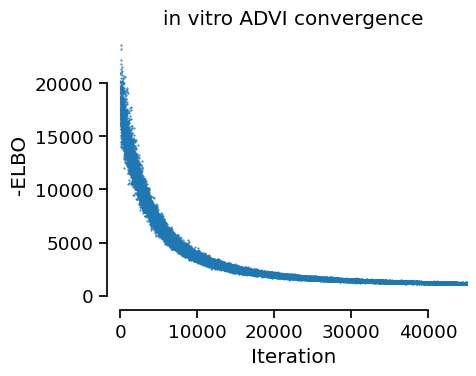

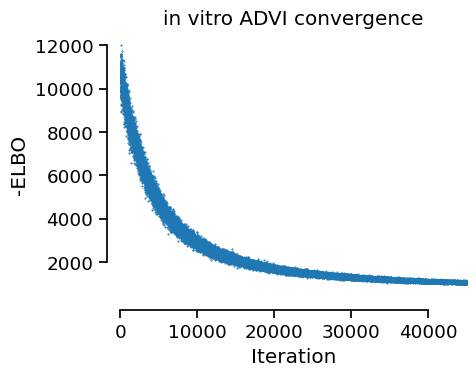

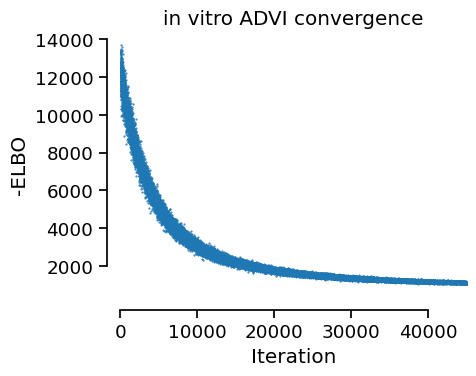

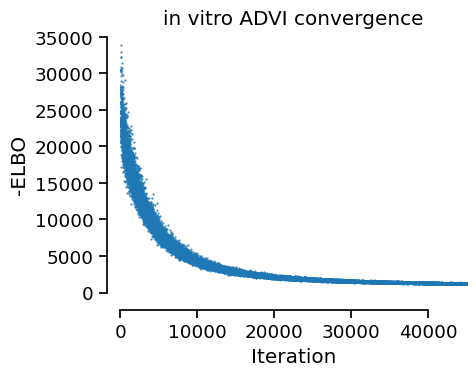

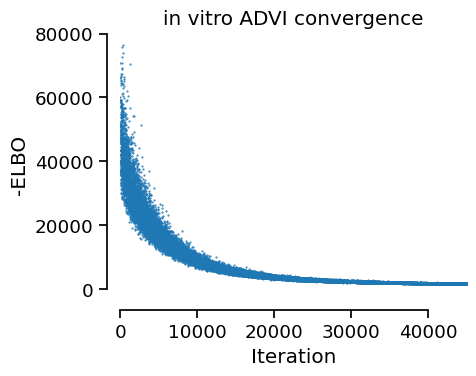

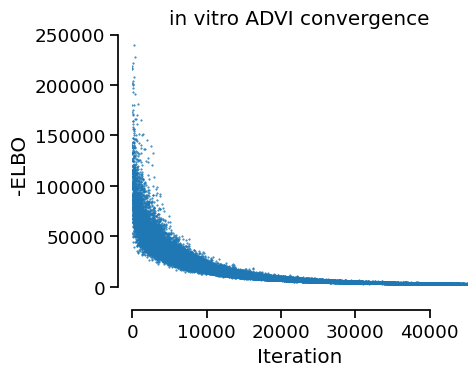

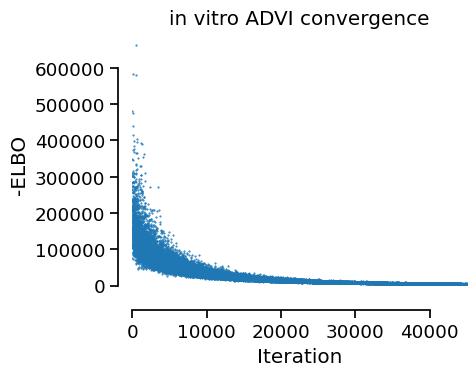

In [11]:
trace05 = run_ADVI(BMCA_obj05)
trace10 = run_ADVI(BMCA_obj10)
trace15 = run_ADVI(BMCA_obj15)
trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace100 = run_ADVI(BMCA_obj100)

In [16]:
# Ey_advi = (trace['posterior']['Ey']).to_numpy().squeeze()
ExTrace_05 = (trace05['posterior']['Ex']).to_numpy().squeeze()
ExTrace_10 = (trace10['posterior']['Ex']).to_numpy().squeeze()
ExTrace_15 = (trace15['posterior']['Ex']).to_numpy().squeeze()
ExTrace_3 = (trace3['posterior']['Ex']).to_numpy().squeeze()
ExTrace_5 = (trace5['posterior']['Ex']).to_numpy().squeeze()
ExTrace_7 = (trace7['posterior']['Ex']).to_numpy().squeeze()
ExTrace_100 = (trace100['posterior']['Ex']).to_numpy().squeeze()

## Calculating FCCs

In [13]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [14]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [45]:
postFCC05 = estimate_CCs(BMCA_obj05, ExTrace_05)
postFCC10 = estimate_CCs(BMCA_obj10, ExTrace_10)
postFCC15 = estimate_CCs(BMCA_obj15, ExTrace_15)
postFCC3 = estimate_CCs(BMCA_obj3, ExTrace_3)
postFCC5 = estimate_CCs(BMCA_obj5, ExTrace_5)
postFCC7 = estimate_CCs(BMCA_obj7, ExTrace_7)
postFCC10 = estimate_CCs(BMCA_obj10, ExTrace_10)

In [132]:
rxn_FCCs = [postFCC05, postFCC10, postFCC15, postFCC3, postFCC5, postFCC7, postFCC10]
pt_labels = ['0.5x', '1.01x', '1.5x', '3x', '5x', '7x', '10x']

In [151]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [169]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vGLK,0.5x,-1.811975,0.047383,0.013496,0.137958,0.040882,0.021435,0.013517,0.006667,0.000890,0.000428,0.000730,-0.000219,-0.001089,0.510589,-0.002625,0.003393
vPGI,0.5x,0.115821,-1.778436,-0.022198,-0.226910,0.186866,0.127027,0.064051,0.040309,0.028691,0.020621,0.024646,0.014582,0.000866,0.338007,0.002087,0.045045
vGLYCO,0.5x,0.223199,-0.109826,-1.043150,-0.441091,-0.086478,-0.061161,-0.028954,-0.023932,-0.017226,-0.009878,-0.013737,-0.012470,-0.002852,0.632246,-0.006874,-0.026257
vTreha,0.5x,0.237482,-0.101579,-0.044702,-1.456950,-0.083141,-0.067567,-0.027995,-0.021063,-0.023949,-0.017248,-0.019528,-0.013355,-0.003250,0.654447,-0.007833,-0.031865
vPFK,0.5x,0.115821,0.221564,-0.022198,-0.226910,-1.813134,0.127027,0.064051,0.040309,0.028691,0.020621,0.024646,0.014582,0.000866,0.338007,0.002087,0.045045


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_26368\622994274.py:13: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

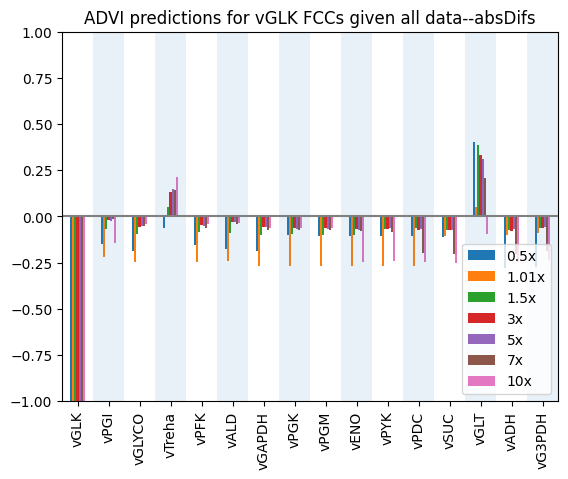

<Figure size 1600x1000 with 0 Axes>

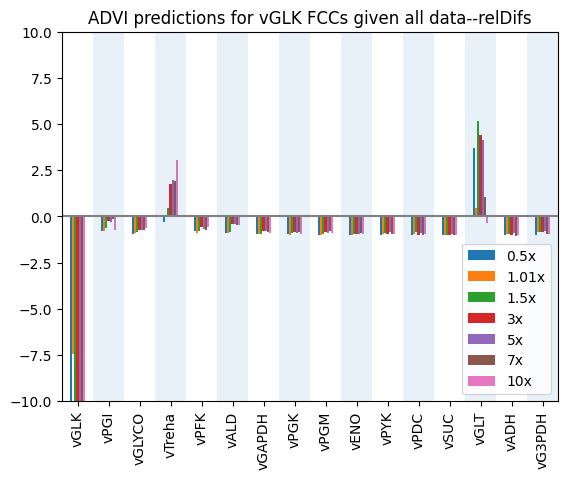

<Figure size 1600x1000 with 0 Axes>

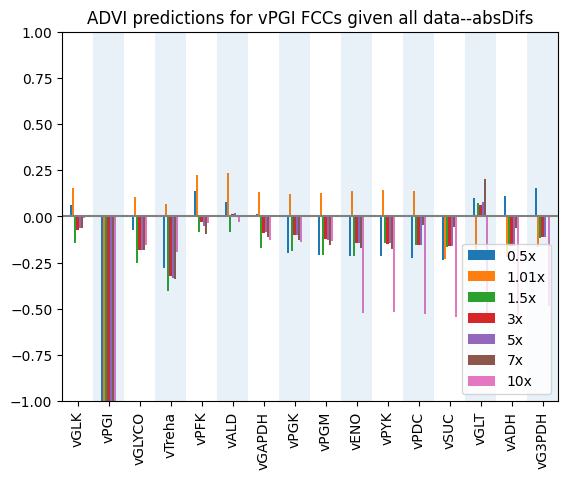

<Figure size 1600x1000 with 0 Axes>

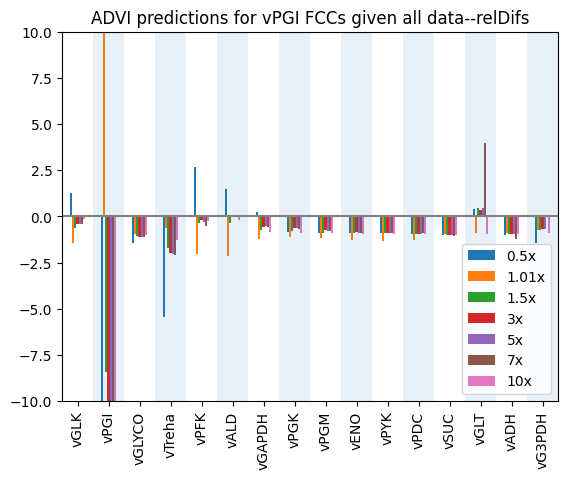

<Figure size 1600x1000 with 0 Axes>

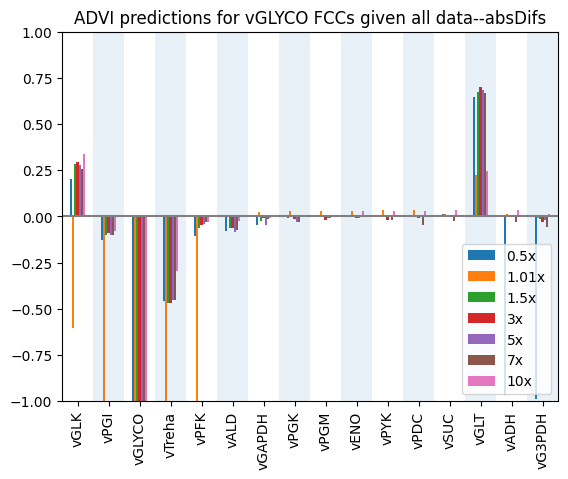

<Figure size 1600x1000 with 0 Axes>

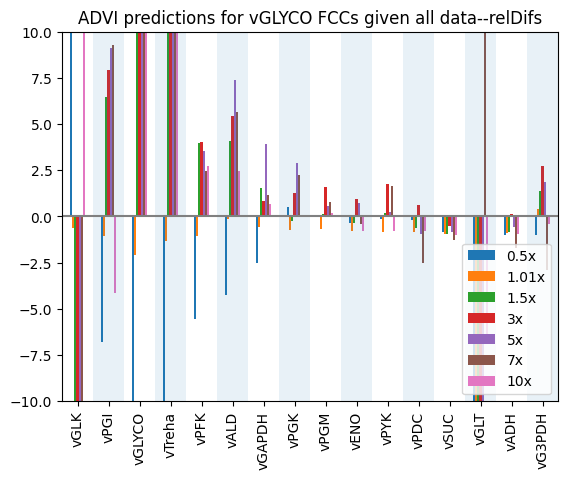

<Figure size 1600x1000 with 0 Axes>

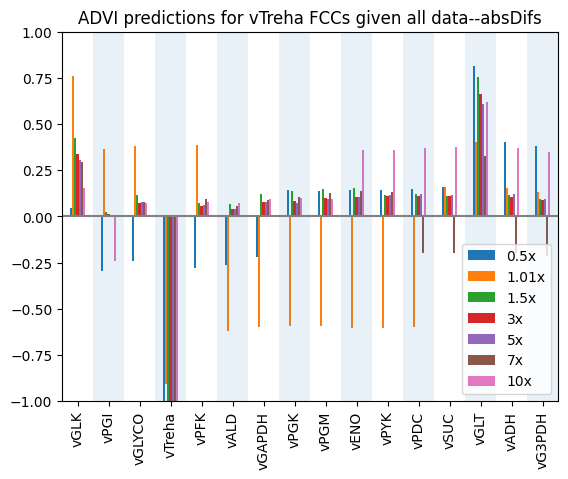

<Figure size 1600x1000 with 0 Axes>

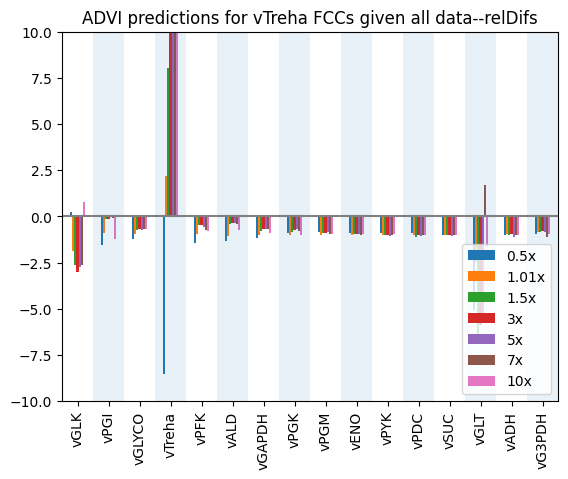

<Figure size 1600x1000 with 0 Axes>

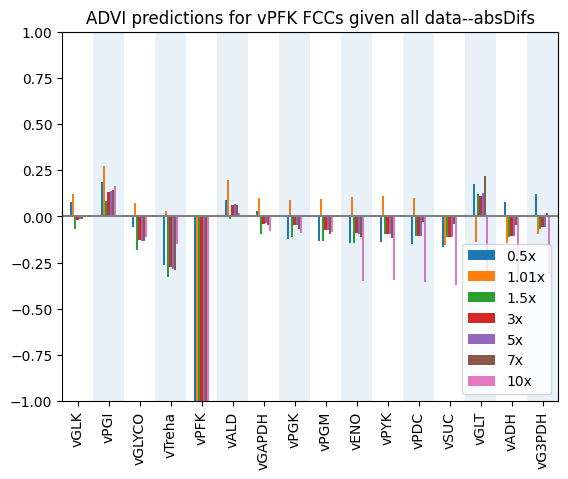

<Figure size 1600x1000 with 0 Axes>

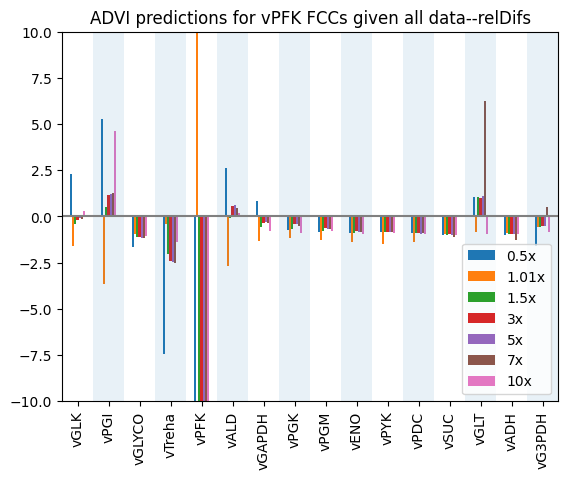

<Figure size 1600x1000 with 0 Axes>

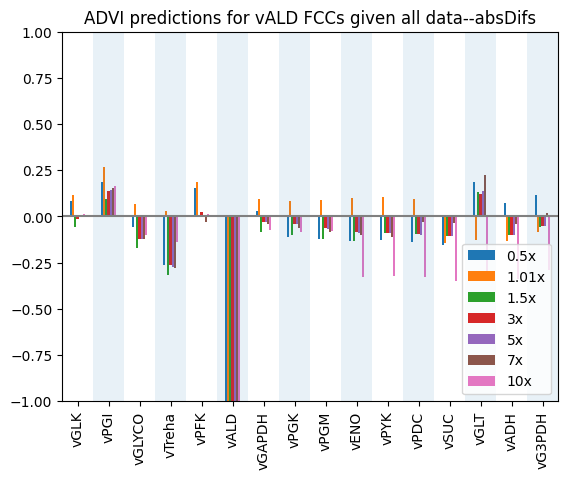

<Figure size 1600x1000 with 0 Axes>

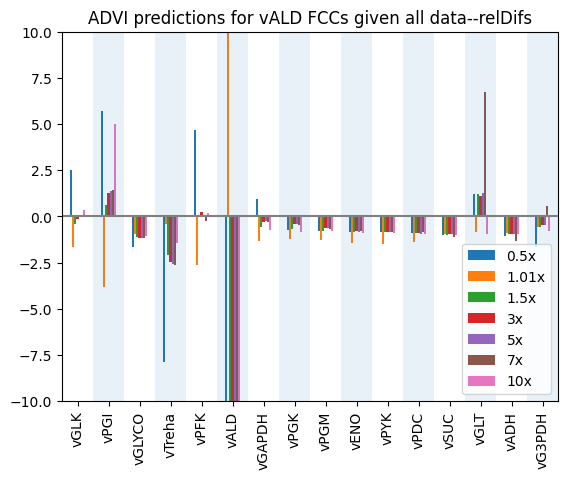

<Figure size 1600x1000 with 0 Axes>

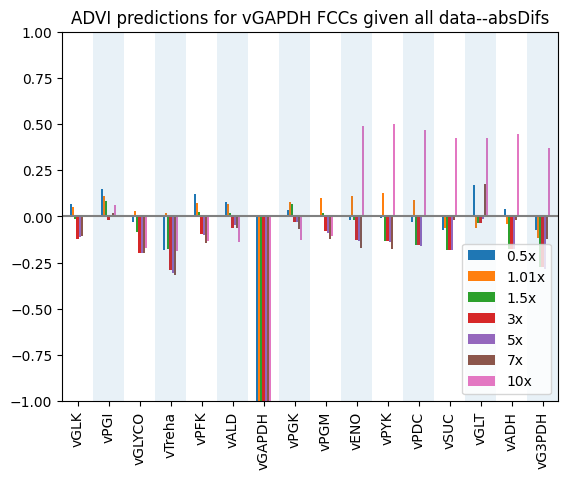

<Figure size 1600x1000 with 0 Axes>

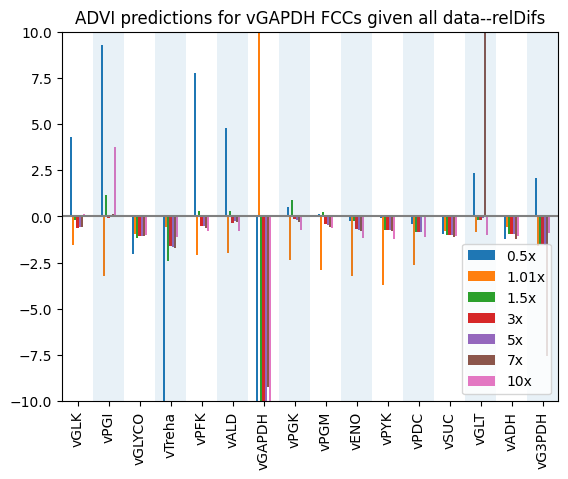

<Figure size 1600x1000 with 0 Axes>

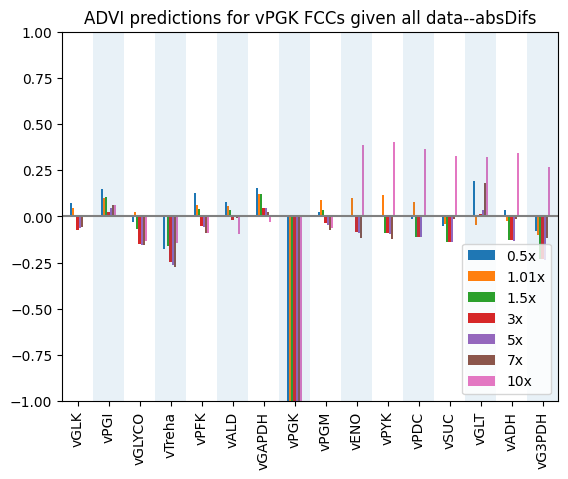

<Figure size 1600x1000 with 0 Axes>

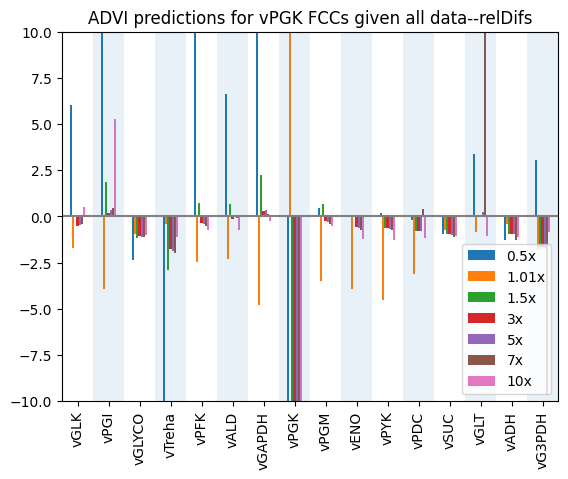

<Figure size 1600x1000 with 0 Axes>

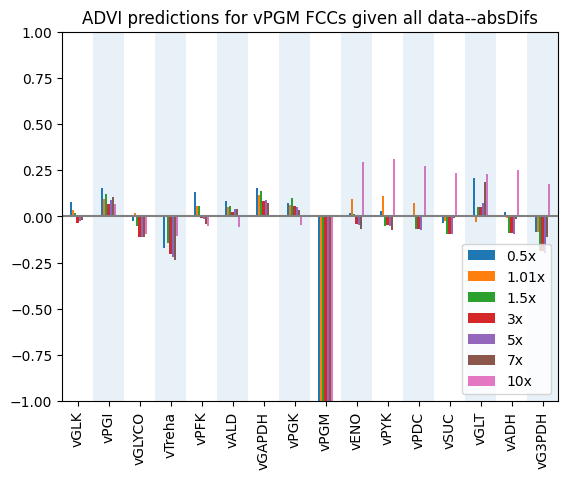

<Figure size 1600x1000 with 0 Axes>

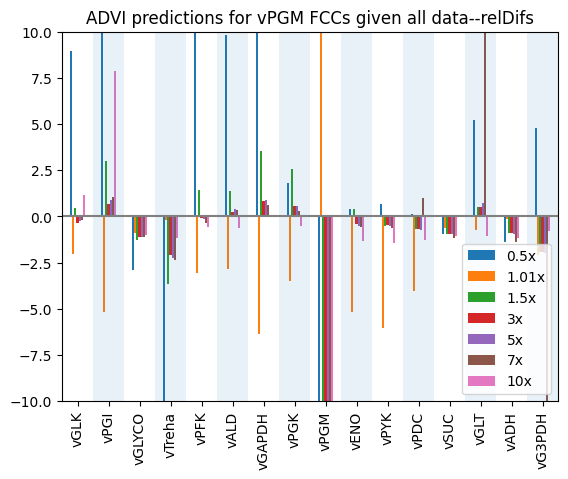

<Figure size 1600x1000 with 0 Axes>

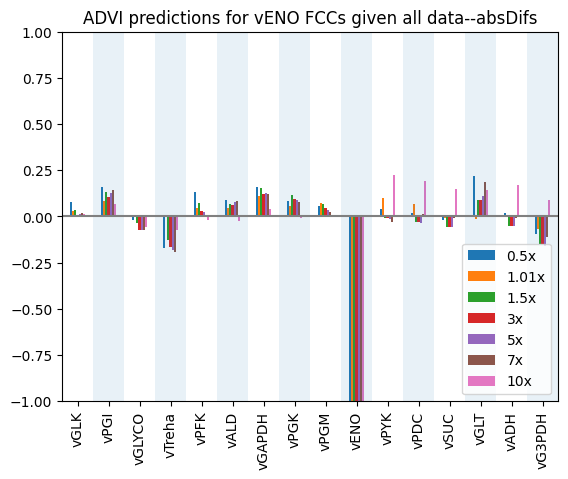

<Figure size 1600x1000 with 0 Axes>

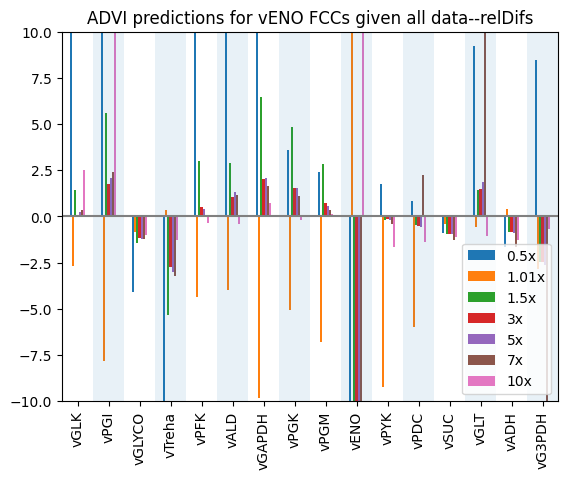

<Figure size 1600x1000 with 0 Axes>

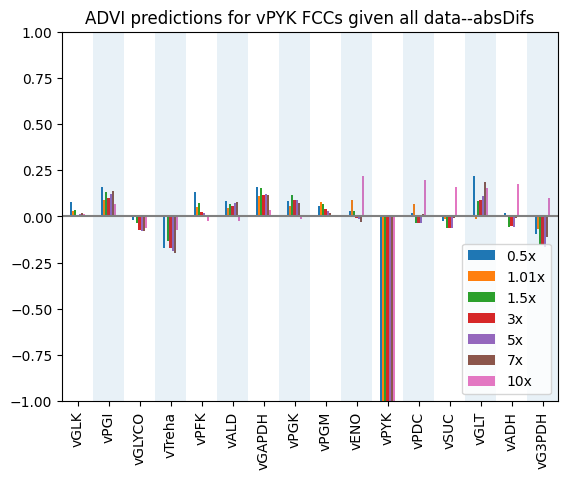

<Figure size 1600x1000 with 0 Axes>

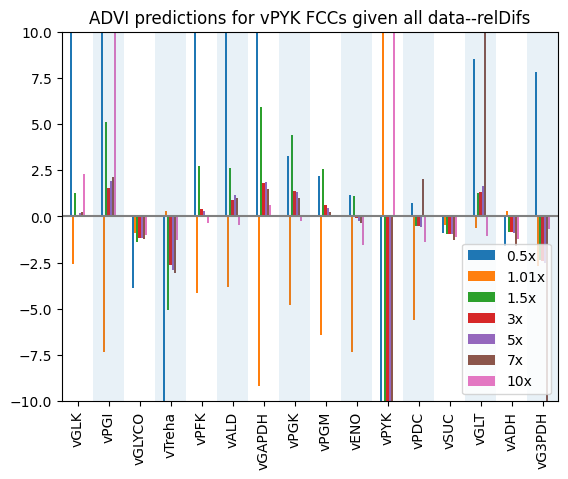

<Figure size 1600x1000 with 0 Axes>

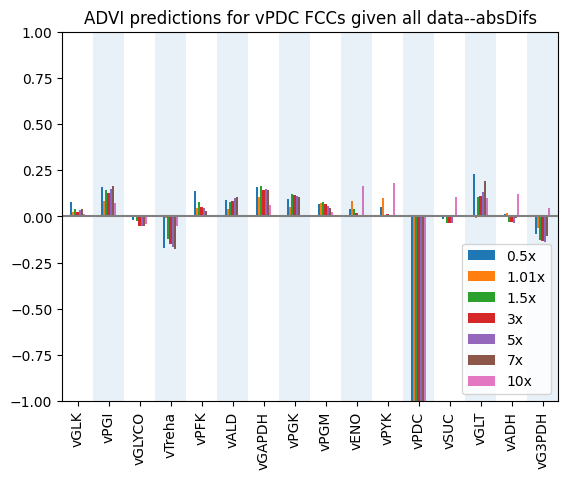

<Figure size 1600x1000 with 0 Axes>

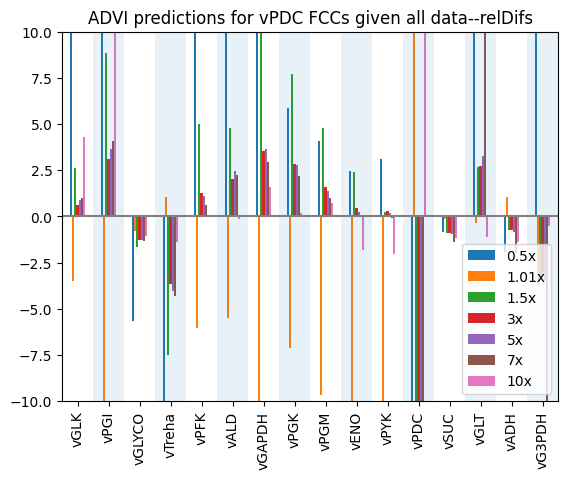

<Figure size 1600x1000 with 0 Axes>

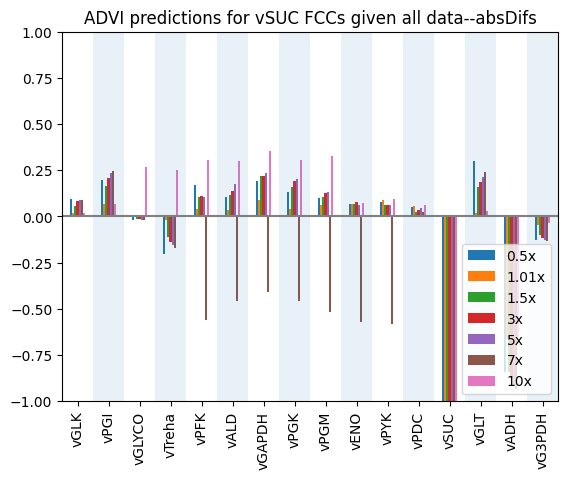

<Figure size 1600x1000 with 0 Axes>

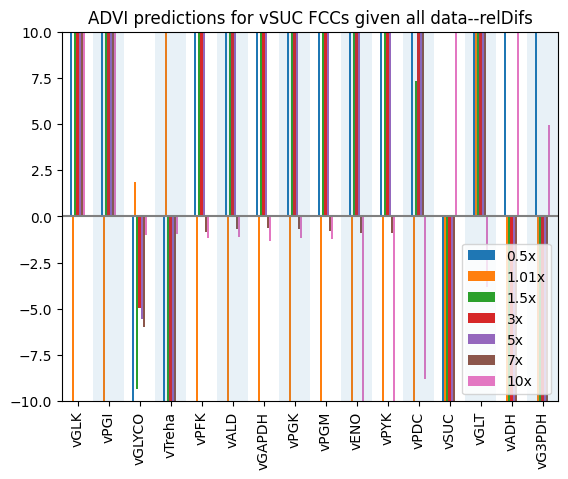

<Figure size 1600x1000 with 0 Axes>

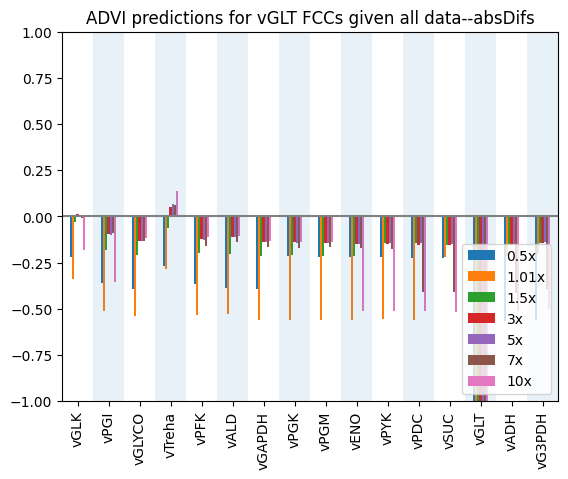

<Figure size 1600x1000 with 0 Axes>

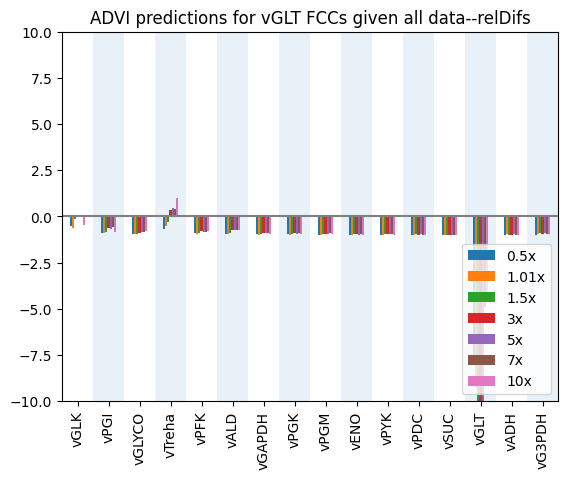

<Figure size 1600x1000 with 0 Axes>

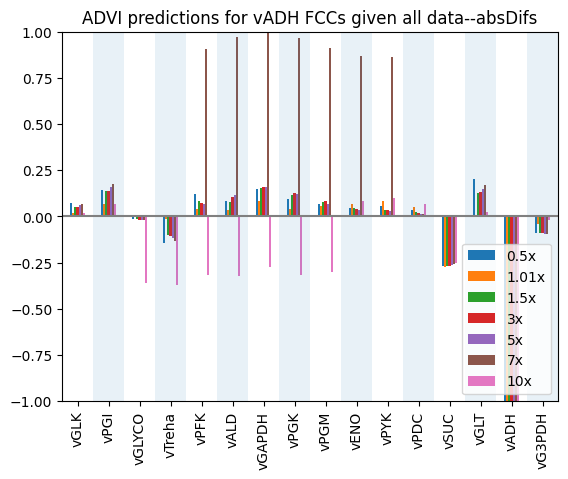

<Figure size 1600x1000 with 0 Axes>

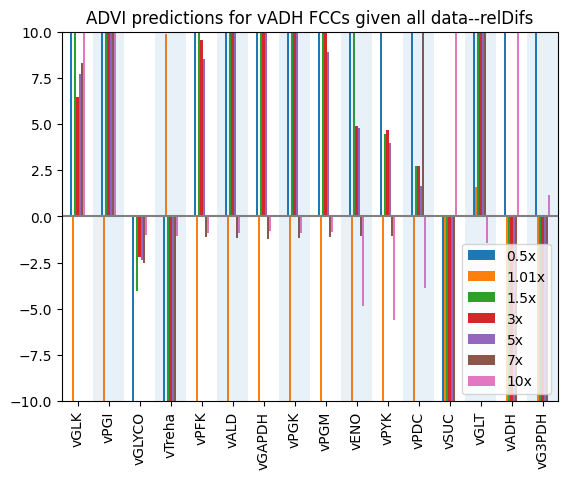

<Figure size 1600x1000 with 0 Axes>

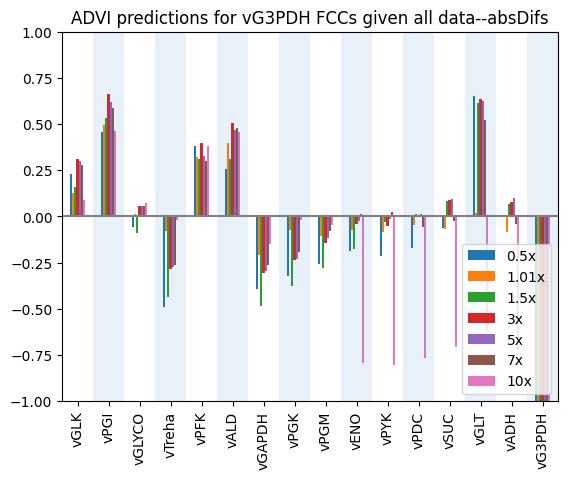

<Figure size 1600x1000 with 0 Axes>

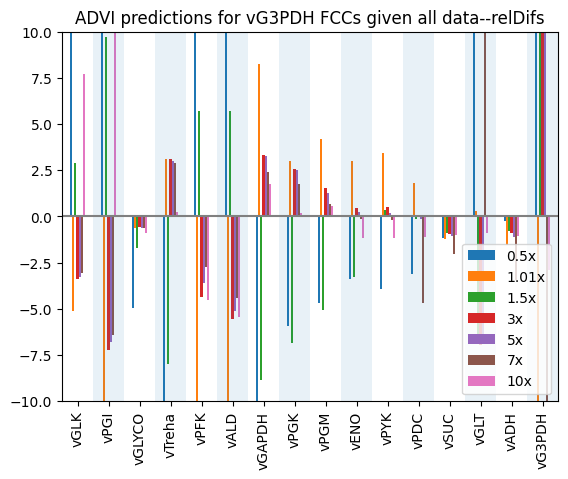

In [183]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')

In [184]:
plt.close("all")

## Evaluating FCC ranking

In [185]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
# gtFCC_rankings

In [ ]:
m1 = gtFCC_rankings.isin([1.0])  
m2 = gtFCC_rankings.isin([2.0])  
m3 = gtFCC_rankings.isin([3.0])  
a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

trueRanks = pd.concat([a,b,c], axis=1)
trueRanks['topThree'] = trueRanks[0] + trueRanks[1] + trueRanks[2]

In [229]:
rxn_FCCs = [postFCC05, postFCC10, postFCC15, postFCC3, postFCC5, postFCC7, postFCC10]
scores = []
for pt_level in rxn_FCCs:
    postFCC_med=pd.DataFrame(np.median(pt_level, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    # m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
    postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
    postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
  
    m1 = postFCC_med_rankings.isin([1.0])  
    m2 = postFCC_med_rankings.isin([2.0])  
    m3 = postFCC_med_rankings.isin([3.0])  
    a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

    prdRanks = pd.concat([a,b,c], axis=1)
    prdRanks['topThree'] = prdRanks[0] + prdRanks[1] + prdRanks[2]

    scores.append([len([i for i in prdRanks['topThree'][rxn] if i in trueRanks['topThree'][rxn]]) for rxn in r.getReactionIds()])

topThreeCheckdf = pd.DataFrame(scores, columns=r.getReactionIds(), index=pt_labels).T

In [233]:
topThreeCheckdf.style.background_gradient(cmap='RdYlBu', axis=None)
# sns.heatmap(topThreeCheckdf, annot=True, cmap='RdYlBu')

,0.5x,1.01x,1.5x,3x,5x,7x,10x
vGLK,2,3,2,3,2,3,2
vPGI,2,1,2,2,1,2,1
vGLYCO,2,3,2,3,2,3,2
vTreha,2,3,2,3,2,3,2
vPFK,2,1,2,2,1,2,0
vALD,1,2,1,2,1,2,1
vGAPDH,1,1,2,3,2,2,0
vPGK,1,2,2,3,2,3,1
vPGM,1,2,2,2,2,3,1
vENO,1,2,2,2,2,3,1


In [235]:
topThreeCheckdf.sum(axis=0)

0.5x     21
1.01x    32
1.5x     31
3x       40
5x       29
7x       43
10x      18
dtype: int64

In [20]:
for i in r.getReactionIds():
    a = gtFCC_rankings.loc[i].values
    b = postFCC_med_rankings.loc[i].values
    spcorr = stats.spearmanr(a,b,nan_policy='omit')
    print(i, spcorr)

vGLK SpearmanrResult(correlation=0.9857142857142855, pvalue=1.9290948746066845e-11)
vPGI SpearmanrResult(correlation=0.9785714285714284, pvalue=2.6454560123987495e-10)
vGLYCO SpearmanrResult(correlation=0.9928571428571429, pvalue=2.1681214863290813e-13)
vTreha SpearmanrResult(correlation=0.9714285714285713, pvalue=1.6870764886091287e-09)
vPFK SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vALD SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vGAPDH SpearmanrResult(correlation=0.9714285714285713, pvalue=1.6870764886091287e-09)
vPGK SpearmanrResult(correlation=0.9714285714285713, pvalue=1.6870764886091287e-09)
vPGM SpearmanrResult(correlation=0.982142857142857, pvalue=8.15733350897873e-11)
vENO SpearmanrResult(correlation=0.9749999999999999, pvalue=7.14370596522927e-10)
vPYK SpearmanrResult(correlation=0.9749999999999999, pvalue=7.14370596522927e-10)
vPDC SpearmanrResult(correlation=0.9714285714285713, pvalue=1.687076488609128